In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [76]:
import pickle # save images
import time # get time stamp of models trained
import shap

## Import text files (image names, labels)

In [4]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

#### Create dataframe with images.txt

_Contains name of images and file path_  
- Split into file path, image name, and folder number

In [5]:
bucket = 'cwbirdsimages'

In [6]:
s3 = boto3.client('s3')
img_txt = s3.get_object(Bucket=bucket, Key='images.txt')

img_names = BytesIO(img_txt['Body'].read())

In [7]:
img_data = pd.read_csv(img_names, header=None, low_memory=False, na_values='n/a')

In [8]:
img_data['file_path'] = img_data[0].apply(lambda x: x.split()[1])
img_data['img_name'] = img_data[0].apply(lambda x: x.split()[0])

img_data['class_id'] = img_data['file_path'].apply(lambda x: x.split('/')[0])

In [9]:
img_data.drop(0, axis=1, inplace=True)

In [10]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  48562 non-null  object
 1   img_name   48562 non-null  object
 2   class_id   48562 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [11]:
# 'class_id' should be int
img_data['class_id'] = img_data['class_id'].apply(lambda x: int(x))

#### Create dataframe of image_class_labels.txt

_Contains name of image file and corresponding folder number_  
- Split into image name, and folder number

In [12]:
s3 = boto3.client('s3')
img_class = s3.get_object(Bucket=bucket, Key='image_class_labels.txt')

img_class_labels = BytesIO(img_class['Body'].read())

In [13]:
labels_df = pd.read_csv(img_class_labels, header=None, low_memory=False, na_values='n/a')

In [14]:
labels_df

,0
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829 817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b 860
2,00019306-9d83-4334-b255-a447742edce3 900
3,0001afd4-99a1-4a67-b940-d419413e23b3 645
4,000332b8-997c-4540-9647-2f0a8495aecf 929
...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a 891
48558,fff926d7-ccad-4788-839e-97af2dd99372 660
48559,fffa33ef-a765-408d-8d66-6efc7f504c71 492
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce 372


In [15]:
labels_df['img_name'] = labels_df[0].apply(lambda x: x.split()[0])
labels_df['class_id'] = labels_df[0].apply(lambda x: x.split()[1])

In [16]:
labels_df.drop(0, axis=1, inplace=True)

In [17]:
labels_df

,img_name,class_id
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,860
2,00019306-9d83-4334-b255-a447742edce3,900
3,0001afd4-99a1-4a67-b940-d419413e23b3,645
4,000332b8-997c-4540-9647-2f0a8495aecf,929
...,...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,891
48558,fff926d7-ccad-4788-839e-97af2dd99372,660
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,492
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,372


In [18]:
# 'class_id' should be int
labels_df['class_id'] = labels_df['class_id'].apply(lambda x: int(x))

In [19]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_name  48562 non-null  object
 1   class_id  48562 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 758.9+ KB


#### Create dataframe with hierarchy.txt

_Contains folder number and class number_  
- Split into folder number and class number

In [20]:
s3 = boto3.client('s3')
hierarchy_txt = s3.get_object(Bucket=bucket, Key='hierarchy.txt')

hierarchy = BytesIO(hierarchy_txt['Body'].read())

In [21]:
hier_df = pd.read_csv(hierarchy, header=None, low_memory=False, na_values='n/a')

In [22]:
hier_df.head()

,0
0,1 0
1,2 0
2,3 0
3,4 0
4,5 0


In [23]:
hier_df['folder_num'] = hier_df[0].apply(lambda x: x.split()[0])
hier_df['class_id'] = hier_df[0].apply(lambda x: x.split()[1])

In [24]:
hier_df.drop(0, axis=1, inplace=True)

In [25]:
hier_df

,folder_num,class_id
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1005,1006,591
1006,1007,259
1007,1008,704
1008,1009,691


#### Create dataframe with classes.txt

_Contains class number and class labels_  
- Split into class number and class labels_

In [26]:
s3 = boto3.client('s3')
classes_txt = s3.get_object(Bucket=bucket, Key='classes.txt')

classes = BytesIO(classes_txt['Body'].read())

In [27]:
classes_df = pd.read_csv(classes, sep='\t', header=None, low_memory=False, na_values='n/a')

In [28]:
classes_df.head()

,0
0,0 Birds
1,"1 Ducks, Geese, and Swans"
2,"2 Grouse, Quail, and Allies"
3,3 Loons
4,4 Grebes


In [29]:
classes_df['class_id'] = classes_df[0].apply(lambda x: x.split(' ', 1)[0])
classes_df['txt_labels'] = classes_df[0].apply(lambda x: x.split(' ', 1)[1])

In [30]:
classes_df.drop(0, axis=1, inplace=True)

In [31]:
# 'class_id' should be int
classes_df['class_id'] = classes_df['class_id'].apply(lambda x: int(x))

## Merge all dataframes

The folder numbers corresponds to the class ids
merge the **img_data** dataframe (containing file path, image name, and class id) and the **classes_df** dataframe (class id and txt_labels)

In [32]:
master_df = img_data.merge(classes_df, on='class_id')

In [33]:
master_df

,file_path,img_name,class_id,txt_labels
0,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817,Oak Titmouse
1,0817/01a472d8e93047a080aae4f958a2ef47.jpg,01a472d8-e930-47a0-80aa-e4f958a2ef47,817,Oak Titmouse
2,0817/036fba7c96374635853511ead2c1c728.jpg,036fba7c-9637-4635-8535-11ead2c1c728,817,Oak Titmouse
3,0817/07814887f59b44cb9b7f399999634fba.jpg,07814887-f59b-44cb-9b7f-399999634fba,817,Oak Titmouse
4,0817/0822865741de43128a6a6c8897387975.jpg,08228657-41de-4312-8a6a-6c8897387975,817,Oak Titmouse
...,...,...,...,...
48557,0627/e0e4460e044e4f90a2087ee711be9d37.jpg,e0e4460e-044e-4f90-a208-7ee711be9d37,627,Harlequin Duck (Female/juvenile)
48558,0627/e363eeb0b467477c8e35be4ff9186e5d.jpg,e363eeb0-b467-477c-8e35-be4ff9186e5d,627,Harlequin Duck (Female/juvenile)
48559,0627/e546eb5307d34eaf870eccc659d314a1.jpg,e546eb53-07d3-4eaf-870e-ccc659d314a1,627,Harlequin Duck (Female/juvenile)
48560,0627/e6d7531c575642b19e41669d140a0cd0.jpg,e6d7531c-5756-42b1-9e41-669d140a0cd0,627,Harlequin Duck (Female/juvenile)


In [34]:
master_df.shape

(48562, 4)

In [35]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 48561
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   48562 non-null  object
 1   img_name    48562 non-null  object
 2   class_id    48562 non-null  int64 
 3   txt_labels  48562 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [36]:
master_df['file_path']

0        0817/0000139e21dc4d0cbfe14cae3c85c829.jpg
1        0817/01a472d8e93047a080aae4f958a2ef47.jpg
2        0817/036fba7c96374635853511ead2c1c728.jpg
3        0817/07814887f59b44cb9b7f399999634fba.jpg
4        0817/0822865741de43128a6a6c8897387975.jpg
                           ...                    
48557    0627/e0e4460e044e4f90a2087ee711be9d37.jpg
48558    0627/e363eeb0b467477c8e35be4ff9186e5d.jpg
48559    0627/e546eb5307d34eaf870eccc659d314a1.jpg
48560    0627/e6d7531c575642b19e41669d140a0cd0.jpg
48561    0627/f70e3f79460443aaa9d033ce06f188c2.jpg
Name: file_path, Length: 48562, dtype: object

In [37]:
master_df['txt_labels'].nunique()

555

## Import images

In [38]:
len(master_df['file_path'])

48562

In [39]:
# grab and resize image from and to s3 bucket

img_dir = 'images' # folder containing all other folders of images
paths = master_df['file_path']

def resize_images_array(img_dir, file_paths):
    # arrays of image pixels
    img_arrays = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for path in tqdm(file_paths):
        s3 = boto3.client('s3')
        try:
            obj = s3.get_object(Bucket=bucket, Key=f'{img_dir}/{path}')
            img_bytes = BytesIO(obj['Body'].read())
            open_img = Image.open(img_bytes)
            arr = np.array(open_img.resize((200,200))) # resize to 200,200. possible to play around with better or worse resolution
            img_arrays.append(arr)
        except:
#             print(path) # get file_path of ones that fail to load
            continue

    return np.array(img_arrays)

##### 9713 images code

In [40]:
# X = resize_images_array(img_dir, master_df['file_path'][::5]) # grabs 9713 images, ~19:30mins

##### 486 images code

In [41]:
# sm_samp = resize_images_array(img_dir, master_df['file_path'][::100])

##### 101 images code

In [42]:
xs_samp = resize_images_array(img_dir, master_df['file_path'][::485])

100%|██████████| 101/101 [00:10<00:00,  9.24it/s]


##### small sample len and shape

In [43]:
# print('length of small sample: ', len(sm_samp))
# sm_samp.shape

In [44]:
print('length of x-small sample: ', len(xs_samp))
xs_samp.shape

length of x-small sample:  101


(101, 200, 200, 3)

#### Show the 3 channels of colors

In [45]:
single_img = master_df['file_path'][985]
single_img

'0776/16398b734cf540e3b0bcc943621e3515.jpg'

In [46]:
obj = s3.get_object(Bucket=bucket, Key=f'images/0776/16398b734cf540e3b0bcc943621e3515.jpg')
img_bytes = BytesIO(obj['Body'].read())
open_img = Image.open(img_bytes)

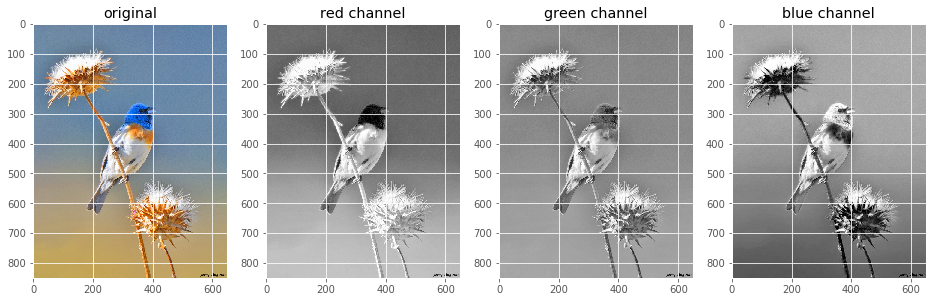

In [47]:
# By stacking these together into a 3-tensor, we can represent a color image as a single object.

fig, axes = plt.subplots(1, 4, figsize=(16,6))

axes[0].imshow(open_img)
axes[0].set_title('original')
for ax, channel, name in zip(axes[1:], open_img.split(), ['red channel', 'green channel', 'blue channel']):
    ax.imshow(channel, cmap='gray')
    ax.set_title(name)

### Create labels and features arrays and normalize features arrays

##### small sample normalize

In [48]:
# # normalize the RBG values
# sm_samp = sm_samp/255.0

In [49]:
# normalize the RBG values
xs_samp = xs_samp/255.0

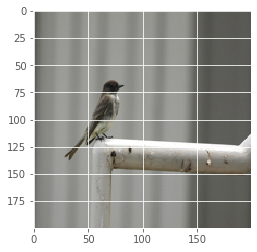

In [50]:
plt.imshow(xs_samp[1])

In [51]:
# grab numeric label
# VALUES MUST BE NP.ARRAYS

label = np.array(master_df['class_id'][::485].values)
y_txt_label = np.array(master_df['txt_labels'][::485].values)

##### y labels need to be one hot encoded

In [52]:
print('Label Minimum: ', master_df['class_id'].unique().min())
print('Label Maximum: ', master_df['class_id'].unique().max())

Label Minimum:  295
Label Maximum:  1010


In [53]:
y = (label.reshape(-1,1) == np.arange(295, 1010)).astype(float)

In [54]:
y_txt_label = y_txt_label.reshape(-1,1)

In [55]:
y_txt_label.shape

(101, 1)

In [56]:
y.shape

(101, 715)

In [57]:
xs_samp.shape

(101, 200, 200, 3)

In [58]:
print(y[:5])
y_txt_label[:5]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([['Oak Titmouse'],
       ['Eastern Phoebe'],
       ['Ruddy Duck (Female/juvenile)'],
       ['Red-naped Sapsucker'],
       ['Painted Bunting (Female/juvenile)']], dtype=object)

## Machine Learning Libraries Import

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Random Forest Classifier

In [60]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# sample = np.array([x.flatten() for x in xs_samp])
# sample.shape

In [61]:
# clf = RandomForestClassifier(n_jobs=-1)

# X_train, X_test, y_train, y_test = train_test_split(sample, y, test_size=0.2, random_state=42)

# print("Train model")
# clf.fit(X_train, y_train)

# print("Predictions")
# predicted = clf.predict(X_test)

# # there are too many labels

# print("Accuracy: ", accuracy_score(y_test, predicted))

## Neural Network Model 1

In [62]:
# keras and tensorflow downloads
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D # CNN
from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set

In [63]:
tf.__version__

'2.2.0'

In [64]:
xs_samp.shape

(101, 200, 200, 3)

['Semipalmated Sandpiper']


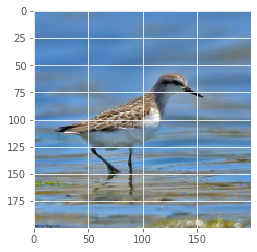

In [65]:
# check to make sure the bird images and labels are aligned
# this is indeed a semipalmated sandpiper

print(y_txt_label[57])
plt.imshow(xs_samp[57]);

1. X, and y defined
- make sure they are arrays!!

2. normalize X values by dividing by 255
3. check images
4. train test split
5. make model Sequential()
6. add input layer
7. add multiple hidden layers
8. ADD FLATTEN LAYER, MUST BE BEFORE OUTPUT
9. add dense layer, which are fully connected layers
10. add output dense layer, will be the amount of labels there are
11. model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
12. model.fit(xtrain, ytrain, epochs) also has validation_split (out of sample) do about 0.1, batchsize: how many at a time, more data requires bigger (20-200 range)
13. model.evaluate(xtest,ytest) returns val loss and val accuracy  

14. model.save('name') saves the model
- to load: new_model = tf.keras.models.load_model('name')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(xs_samp, y, test_size=0.2, random_state=42)

In [67]:
X_train[0][0][0]

array([0.41568627, 0.45098039, 0.41960784])

In [68]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (80, 200, 200, 3)
X_test shape:  (21, 200, 200, 3)
y_train shape:  (80, 715)
y_test shape:  (21, 715)


In [70]:
model = Sequential()

model.add(Dense(10, activation='relu', input_shape=[200,200,3]))
model.add(Flatten())
model.add(Dense(715, activation='softmax')) # have to have same amount as y_train.shape[1]

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200, 200, 10)      40        
_________________________________________________________________
flatten (Flatten)            (None, 400000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 715)               286000715 
Total params: 286,000,755
Trainable params: 286,000,755
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [75]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
3/3 [==============================] - 5s 2s/step - loss: 100.9861 - accuracy: 0.0125
Epoch 2/3
3/3 [==============================] - 5s 2s/step - loss: 89.6985 - accuracy: 0.0000e+00
Epoch 3/3
3/3 [==============================] - 5s 2s/step - loss: 59.7286 - accuracy: 0.0500
